import the necessary package

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

initialize the initial learning rate, number of epochs to train for and batch size

In [2]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [3]:
DIRECTORY = r"D:/Pyhton/FMD/dataset"
CATEGORIES = ["with_mask", "without_mask"]

grab the list of images in our dataset directory, then initialize the list of data (i.e., images) and class image

In [4]:
print("[INFO] loading images...")

[INFO] loading images...


In [5]:
data = []
labels = []

In [6]:
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

perform one-hot encoding on the labels

In [7]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [8]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [9]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

construct the training image generator for data augmentation

In [10]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

load the MobileNetV2 network, ensuring the head FC layer sets are left off

In [11]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

C:\Users\arjun\AppData\Local\Temp\ipykernel_17876\2912745669.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(weights="imagenet", include_top=False,


construct the head of the model that will be placed on top of the base model

In [12]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

place the head FC model on top of the base model (this will become the actual model we will train)

In [13]:
model = Model(inputs=baseModel.input, outputs=headModel)

loop over all layers in the base model and freeze them so they will *not* be updated during the first training process

In [14]:
for layer in baseModel.layers:
	layer.trainable = False


compile our model

In [15]:
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


C:\Users\arjun\AppData\Roaming\Python\Python311\site-packages\keras\src\optimizers\base_optimizer.py:31: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


train the head of the network

In [16]:
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...


Epoch 1/20


C:\Users\arjun\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


36/36 ━━━━━━━━━━━━━━━━━━━━ 29s 606ms/step - accuracy: 0.5469 - loss: 0.9010 - val_accuracy: 0.8408 - val_loss: 0.3945
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8750 - loss: 0.1950 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/20


c:\Program Files\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 555ms/step - accuracy: 0.8612 - loss: 0.3765 - val_accuracy: 0.9723 - val_loss: 0.1984
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.1108 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 560ms/step - accuracy: 0.9581 - loss: 0.1948 - val_accuracy: 0.9862 - val_loss: 0.1199
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9688 - loss: 0.0660 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 552ms/step - accuracy: 0.9742 - loss: 0.1364 - val_accuracy: 0.9931 - val_loss: 0.0785
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9688 - loss: 0.0702 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 553ms/step - accuracy: 0.9859 - loss: 0.0963 - val_accuracy: 0.9931 - val_loss: 0.0600
Epoch 10/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9688 - loss: 0.0922 - val_ac

make predictions on the testing set

In [17]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 503ms/step


for each image in the testing set we need to find the index of the label with corresponding largest predicted probability

In [18]:
predIdxs = np.argmax(predIdxs, axis=1)

show a nicely formatted classification report

In [19]:
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      1.00      1.00       200
without_mask       1.00      0.98      0.99        89

    accuracy                           0.99       289
   macro avg       1.00      0.99      0.99       289
weighted avg       0.99      0.99      0.99       289



serialize the model to disk

In [20]:
print("[INFO] saving mask detector model...")
model.save("D:/Pyhton/FMD/mask_detector.model/mask_detector.model.h5")

[INFO] saving mask detector model...


plot the training loss and accuracy

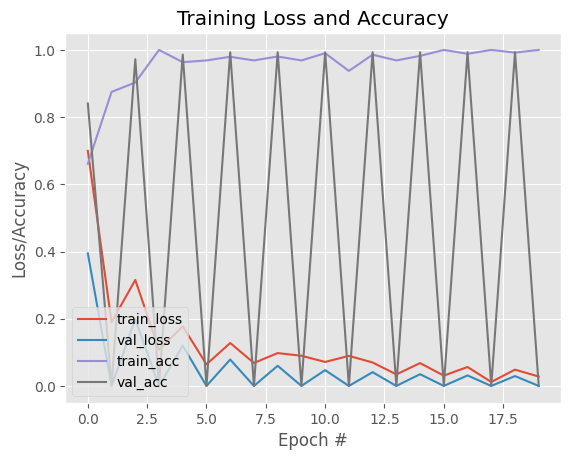

In [21]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

import the necessary packages

In [22]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import numpy as np
import imutils
import time
import cv2
import os

Use the correct relative paths or absolute paths

In [23]:
prototxtPath = "D:/Pyhton/FMD/face_detector/deploy.prototxt"
weightsPath = "D:/Pyhton/FMD/face_detector/res10_300x300_ssd_iter_140000.caffemodel"

import the necessary packages

In [24]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import numpy as np
import imutils
import time
import cv2
import os

ApyCoder A youtube channel for machine learning and Ai and python

In [25]:
def detect_and_predict_mask(frame, faceNet, maskNet):
	# grab the dimensions of the frame and then construct a blob
	# from it
	(h, w) = frame.shape[:2]
	blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224),
		(104.0, 177.0, 123.0))

	# pass the blob through the network and obtain the face detections
	faceNet.setInput(blob)
	detections = faceNet.forward()
	print(detections.shape)

	# initialize our list of faces, their corresponding locations,
	# and the list of predictions from our face mask network
	faces = []
	locs = []
	preds = []

	# loop over the detections
	for i in range(0, detections.shape[2]):
		# extract the confidence (i.e., probability) associated with
		# the detection
		confidence = detections[0, 0, i, 2]

		# filter out weak detections by ensuring the confidence is
		# greater than the minimum confidence
		if confidence > 0.5:
			# compute the (x, y)-coordinates of the bounding box for
			# the object
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			# ensure the bounding boxes fall within the dimensions of
			# the frame
			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			# extract the face ROI, convert it from BGR to RGB channel
			# ordering, resize it to 224x224, and preprocess it
			face = frame[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (224, 224))
			face = img_to_array(face)
			face = preprocess_input(face)

			# add the face and bounding boxes to their respective
			# lists
			faces.append(face)
			locs.append((startX, startY, endX, endY))

	# only make a predictions if at least one face was detected
	if len(faces) > 0:
		# for faster inference we'll make batch predictions on *all*
		# faces at the same time rather than one-by-one predictions
		# in the above `for` loop
		faces = np.array(faces, dtype="float32")
		preds = maskNet.predict(faces, batch_size=32)

	# return a 2-tuple of the face locations and their corresponding
	# locations
	return (locs, preds)

load our serialized face detector model from disk

In [26]:
prototxtPath = r"D:/Pyhton/FMD/face_detector/deploy.prototxt"
weightsPath = r"D:/Pyhton/FMD/face_detector/res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

load the face mask detector model from disk

In [27]:
maskNet = load_model("D:/Pyhton/FMD/mask_detector.model/mask_detector.model.h5")

initialize the video stream

In [28]:
print("[INFO] starting video stream...")
vs = VideoStream(src=0).start()

[INFO] starting video stream...


loop over the frames from the video stream

In [29]:
while True:
	# grab the frame from the threaded video stream and resize it
	# to have a maximum width of 400 pixels
	frame = vs.read()
	frame = imutils.resize(frame, width=400)

	# detect faces in the frame and determine if they are wearing a
	# face mask or not
	(locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)

	# loop over the detected face locations and their corresponding
	# locations
	for (box, pred) in zip(locs, preds):
		# unpack the bounding box and predictions
		(startX, startY, endX, endY) = box
		(mask, withoutMask) = pred

		# determine the class label and color we'll use to draw
		# the bounding box and text
		label = "Mask" if mask > withoutMask else "No Mask"
		color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

		# include the probability in the label
		label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

		# display the label and bounding box rectangle on the output
		# frame
		cv2.putText(frame, label, (startX, startY - 10),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
		cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

	# show the output frame
	cv2.imshow("Mask Detection", frame)
	key = cv2.waitKey(1) & 0xFF

	# if the `q` key was pressed, break from the loop
	if key == ord("q"):
		break

# do a bit of cleanup
cv2.destroyAllWindows()
vs.stop()

(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
(1, 1, 200, 7)
1/1